# Implémentation de Policy Iteration, Value Iteration et Epsilon-Greedy dans un environnement Frozen Lake



## Introduction :
L'objectif de ce TP est d'implémenter et de comparer trois algorithmes fondamentaux en apprentissage par renforcement : Policy Iteration, Value Iteration et l'algorithme Epsilon-Greedy. Ces algorithmes seront appliqués à un environnement Frozen Lake, représenté graphiquement.


Environnement Frozen Lake :
Le Frozen Lake est un environnement de grille où un agent (en bas à droite) doit naviguer à travers une surface glacée  pour atteindre un objectif (en haut à gauche) tout en évitant des cases dangereuses. La grille est représentée ici graphiquement, et chaque case peut être soit une case gelée (sûr, reward = 0), une case dangereuse (trou, reward = -10), ou l'emplacement de l'objectif (reward = 10). L'agent peut se déplacer vers la gauche, droite, en haut ou en bas.
Utiliser le dessin graphique pour définir les valeurs initiales des états et les récompenses associées.

**Toute information non précisée sera laissée libre au choix du développeur.se.et précisée dans votre notebook**
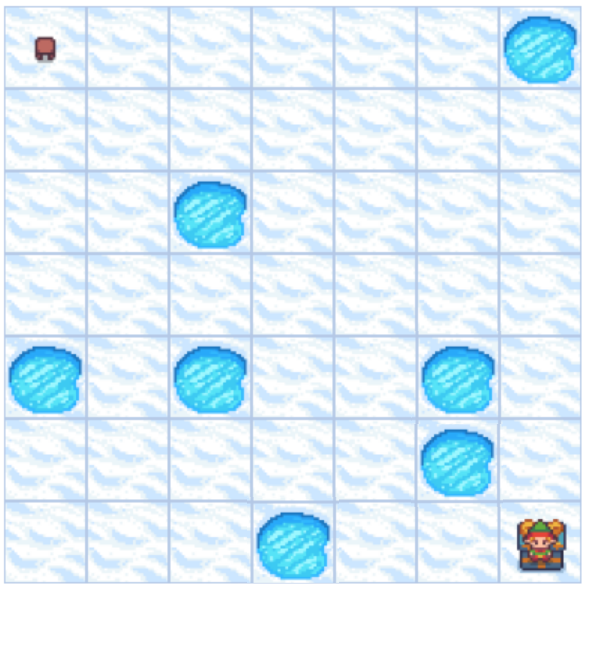
## Rappel de Q-learing
L'algorithme Q-Learning nous permet d'estimer la Q fonction optimale en utilisant uniquement les trajectoires du MDP obtenues en suivant une certaine politique d'exploration.

Q-learning avec une exploration de type $\varepsilon$-greedy effectue la mise à jour suivante au temps $t$ :

1. Dans l'état $s_t$, on effectue une action $a_t$ telle que $a_t$ est aléatoire avec une probabilité $\varepsilon$ et $a_t \in \arg\max_a \hat{Q}_t(s_t,a) $ avec une probabilité $1-\varepsilon$ ;
2. Observer $s_{t+1}$ et la récompense $r_t$ ;
3. Calculer $\delta_t = r_t + \gamma   \max_a (\hat{Q}_t(s_{t+1}, a) - \hat{Q}_t(s_t, a_t))$ ;
4. Mettre à jour $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\} $.





Tâches à accomplir :

*   Policy Iteration (1/4):
      Implémenter l'algorithme de Policy Iteration pour résoudre le problème du Frozen Lake. Afficher les Q-table et Q-policy obtenues.
         

*    Value Iteration (1/4):
        Implémenter l'algorithme de Value Iteration pour résoudre le problème du Frozen Lake. Afficher les valeurs d'état obtenue. Fixer un seuil d'arrêt δ en justifiant.
        

*    Q-learning (stratégie de choix : Epsilon-Greedy) (1/4):
        Implémenter l'algorithme Epsilon-Greedy pour la prise de décision de l'agent dans l'environnement Frozen Lake.
        Utiliser différentes valeurs de ϵ et afficher les Q-tables obtenues.
        

*    Comparaison des algorithmes (1/4):
        Comparer les performances des trois algorithmes en termes de convergence, nombre d'itérations nécessaires, et qualité de la politique finale. Vous pouvez représenter la politique de l'agent à travers la grille de jeu.
        Analyser l'impact du paramètre epsilon dans l'algorithme Epsilon-Greedy sur l'exploration de l'agent.

**L'utilisation de la librairie gym est interdite. Seule les librairies numpy et random sont autorisées pour l'impémentation de l'algorithme. Toutes les librairies graphiques (matplot etc...) sont autorisées pour l'interprétation des résultats**.


Value Iteration convergée en 13 itérations


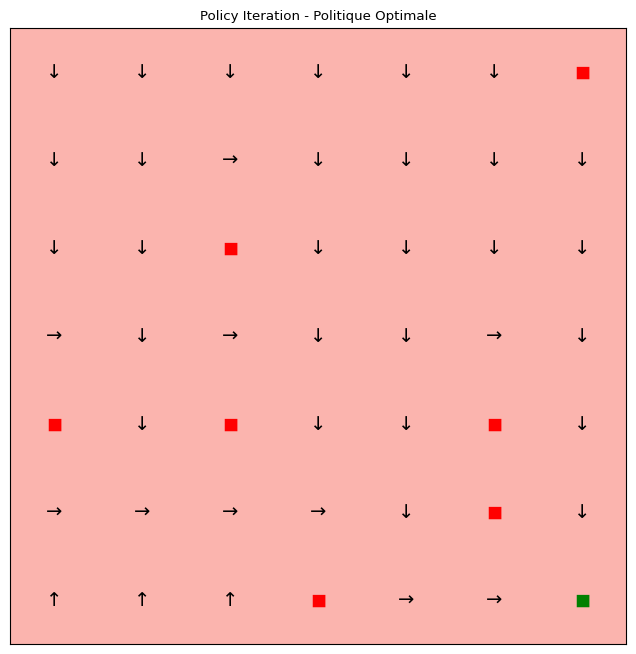

Policy Iteration convergée en 12 itérations


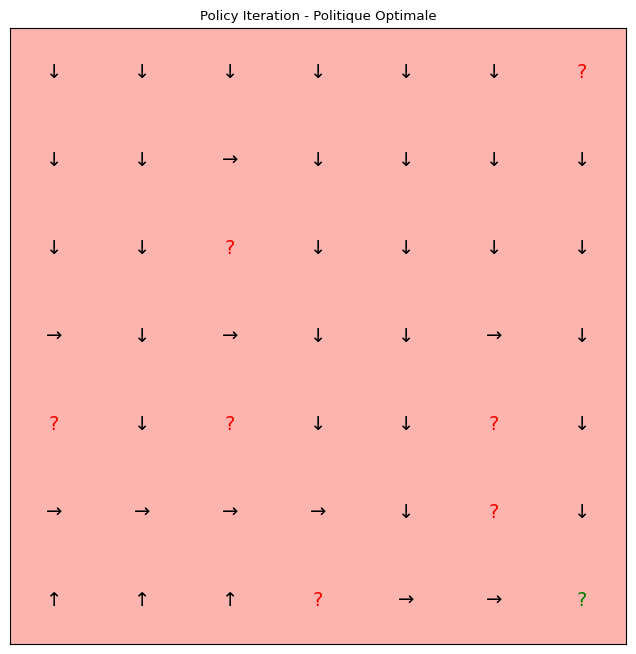

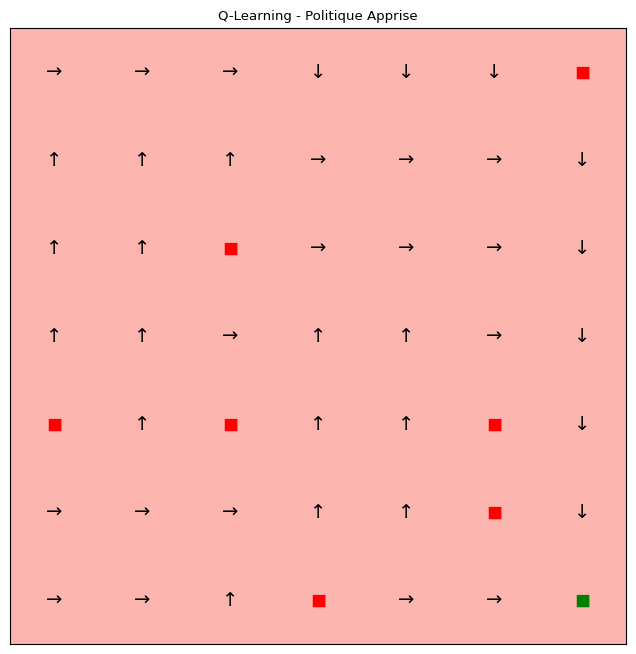

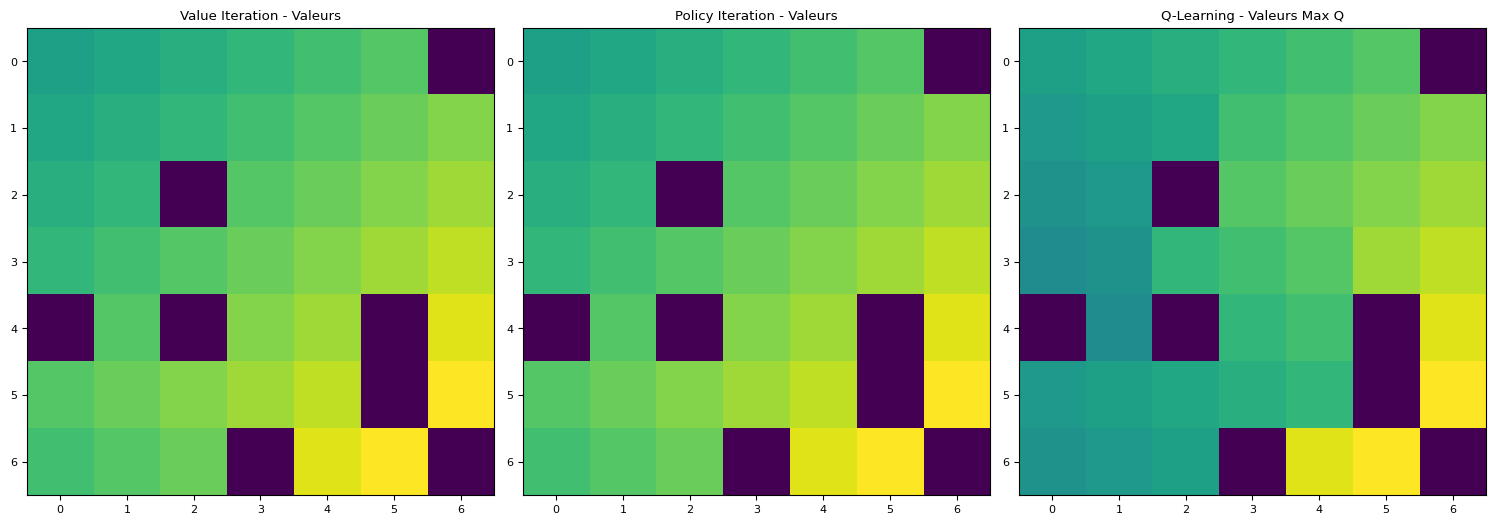

In [94]:
import numpy as np
import random
import matplotlib.pyplot as plt

# =============================================
# Configuration de l'environnement 
# =============================================
GRID_WIDTH = 7
GRID_HEIGHT = 7
DIMENSIONS = (GRID_HEIGHT, GRID_WIDTH)
DANGEROUS_STATES = [(0, 6), (2, 2), (4, 0), (4, 2), (4, 5), (5, 5), (6, 3)]
GOAL_STATE = (6, 6)
ACTIONS = ["haut", "bas", "gauche", "droite", "manger"]

# Initialisation des actions possibles par état
list_state_action = np.empty(DIMENSIONS, dtype=object)
for i in range(GRID_HEIGHT):
    for j in range(GRID_WIDTH):
        actions = []
        if i > 0: actions.append("haut")
        if i < GRID_HEIGHT-1: actions.append("bas")
        if j > 0: actions.append("gauche")
        if j < GRID_WIDTH-1: actions.append("droite")
        actions.append("manger")
        list_state_action[i, j] = actions

# =============================================
# Fonctions de base de l'environnement
# =============================================
def transition_reward(state, action):
    """Fonction de transition avec gestion des états dangereux"""
    i, j = state
    
    # Calcul du prochain état
    if action == "haut": next_state = (max(0, i-1), j)
    elif action == "bas": next_state = (min(GRID_HEIGHT-1, i+1), j)
    elif action == "gauche": next_state = (i, max(0, j-1))
    elif action == "droite": next_state = (i, min(GRID_WIDTH-1, j+1))
    else: next_state = (i, j)  # Pour 'manger'
    
    # Calcul de la récompense
    if next_state == GOAL_STATE:
        return next_state, 10
    if next_state in DANGEROUS_STATES:
        return state, -10  # Rebond et pénalité
    return next_state, 0

def is_terminal(state):
    return state == GOAL_STATE or state in DANGEROUS_STATES

# =============================================
# Algorithme Value Iteration
# =============================================
class ValueIteration:
    def __init__(self, gamma=0.95, theta=1e-6):
        self.V = np.zeros(DIMENSIONS)
        self.gamma = gamma
        self.theta = theta
        
    def run(self):
        iteration = 0
        while True:
            delta = 0
            V_new = np.copy(self.V)
            for i in range(GRID_HEIGHT):
                for j in range(GRID_WIDTH):
                    if is_terminal((i, j)): continue
                    
                    max_value = -np.inf
                    for action in list_state_action[i, j]:
                        (ni, nj), reward = transition_reward((i, j), action)
                        value = reward + self.gamma * self.V[ni, nj]
                        max_value = max(max_value, value)
                    delta = max(delta, abs(V_new[i, j] - max_value))
                    V_new[i, j] = max_value
                    
            self.V = V_new
            iteration += 1
            if delta < self.theta:
                print(f"Value Iteration convergée en {iteration} itérations")
                break
        return self.extract_policy()
    
    def extract_policy(self):
        policy = np.empty(DIMENSIONS, dtype=object)
        for i in range(GRID_HEIGHT):
            for j in range(GRID_WIDTH):
                if is_terminal((i, j)):
                    policy[i, j] = 'terminal'
                    continue
                
                best_value = -np.inf
                best_action = None
                for action in list_state_action[i, j]:
                    (ni, nj), reward = transition_reward((i, j), action)
                    value = reward + self.gamma * self.V[ni, nj]
                    if value > best_value:
                        best_value = value
                        best_action = action
                policy[i, j] = best_action
        return self.V, policy

# =============================================
# Algorithme Policy Iteration
# =============================================
class PolicyIteration:
    def __init__(self, gamma=0.95, theta=1e-4):
        
        self.gamma = gamma
        self.theta = theta
        self.V = np.zeros(DIMENSIONS)
        self.policy = np.empty(DIMENSIONS, dtype=object)
        # Initialisation aléatoire de la politique
        for i in range(GRID_HEIGHT):
            for j in range(GRID_WIDTH):
                if not is_terminal((i, j)):
                    self.policy[i, j] = random.choice(list_state_action[i, j])
    
    def run(self):
        iteration = 0
        while True:
            # Évaluation de la politique
            while True:
                delta = 0
                for i in range(GRID_HEIGHT):
                    for j in range(GRID_WIDTH):
                        if is_terminal((i, j)): continue
                        
                        old_value = self.V[i, j]
                        action = self.policy[i, j]
                        (ni, nj), reward = transition_reward((i, j), action)
                        self.V[i, j] = reward + self.gamma * self.V[ni, nj]
                        delta = max(delta, abs(old_value - self.V[i, j]))
                if delta < self.theta: break
                
            # Amélioration de la politique
            policy_stable = True
            for i in range(GRID_HEIGHT):
                for j in range(GRID_WIDTH):
                    if is_terminal((i, j)): continue
                    
                    old_action = self.policy[i, j]
                    best_value = -np.inf
                    best_action = None
                    for action in list_state_action[i, j]:
                        (ni, nj), reward = transition_reward((i, j), action)
                        value = reward + self.gamma * self.V[ni, nj]
                        if value > best_value:
                            best_value = value
                            best_action = action
                    self.policy[i, j] = best_action
                    if best_action != old_action:
                        policy_stable = False
                        
            iteration += 1
            if policy_stable:
                print(f"Policy Iteration convergée en {iteration} itérations")
                return self.V, self.policy

# =============================================
# Algorithme Q-Learning avec Epsilon-Greedy
# =============================================
class QLearning:
    def __init__(self, gamma=0.95, alpha=0.5, epsilon=0.5, 
                 episodes=20000, epsilon_decay=0.995):
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.episodes = episodes
        self.epsilon_decay = epsilon_decay
        self.Q = np.zeros((*DIMENSIONS, len(ACTIONS)))
        self.action_idx = {a: i for i, a in enumerate(ACTIONS)}
        self.start_states = [(i, j) for i in range(GRID_HEIGHT) 
                           for j in range(GRID_WIDTH) if not is_terminal((i, j))]
    
    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(list_state_action[state])
        else:
            i, j = state
            q_values = [self.Q[i, j, self.action_idx[a]] for a in list_state_action[state]]
            return list_state_action[state][np.argmax(q_values)]
    
    def run(self):
        for ep in range(self.episodes):
            state = random.choice(self.start_states)
            
            while not is_terminal(state):
                action = self.choose_action(state)
                (ni, nj), reward = transition_reward(state, action)
                old_i, old_j = state
                a_idx = self.action_idx[action]
                
                # Mise à jour Q-learning
                next_max = np.max(self.Q[ni, nj]) if not is_terminal((ni, nj)) else 0
                self.Q[old_i, old_j, a_idx] += self.alpha * (
                    reward + self.gamma * next_max - self.Q[old_i, old_j, a_idx]
                )
                
                state = (ni, nj)
            
            # Décay de l'exploration
            self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)
        
        return self.extract_policy()
    
    def extract_policy(self):
        policy = np.empty(DIMENSIONS, dtype=object)
        for i in range(GRID_HEIGHT):
            for j in range(GRID_WIDTH):
                if is_terminal((i, j)):
                    policy[i, j] = 'terminal'
                else:
                    q_values = [self.Q[i, j, self.action_idx[a]] for a in list_state_action[i, j]]
                    policy[i, j] = list_state_action[i, j][np.argmax(q_values)]
        return self.Q, policy

# =============================================
# Visualisation des résultats
# =============================================
def plot_policy(policy, title):
    arrow_map = {'haut': '↑', 'bas': '↓', 'gauche': '←', 'droite': '→', 'manger': '🍽', 'terminal': '◼'}
    plt.figure(figsize=(10, 8))
    plt.imshow(np.zeros(DIMENSIONS), cmap='Pastel1')
    
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            symbol = arrow_map[policy[i, j]] if policy[i, j] in arrow_map else '?'
            color = 'red' if (i, j) in DANGEROUS_STATES else 'green' if (i, j) == GOAL_STATE else 'black'
            plt.text(j, i, symbol, ha='center', va='center', color=color, fontsize=14)
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# =============================================
# Exécution et comparaison des algorithmes
# =============================================
if __name__ == "__main__":
    # Value Iteration
    vi = ValueIteration(gamma=0.95)
    V_vi, policy_vi = vi.run()
    plot_policy(policy_vi, "Policy Iteration - Politique Optimale")
    
    # Policy Iteration
    pi = PolicyIteration(gamma=0.95)
    V_pi, policy_pi = pi.run()
    plot_policy(policy_pi, "Policy Iteration - Politique Optimale")
    
    # Q-Learning
    ql = QLearning(episodes=20000, alpha=0.5, epsilon=0.5)
    Q_table, policy_ql = ql.run()
    plot_policy(policy_ql, "Q-Learning - Politique Apprise")
    
    # Comparaison des politiques
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(V_vi, cmap='viridis')
    plt.title("Value Iteration - Valeurs")
    plt.subplot(132)
    plt.imshow(V_pi, cmap='viridis')
    plt.title("Policy Iteration - Valeurs")
    plt.subplot(133)
    plt.imshow(np.max(Q_table, axis=2), cmap='viridis')
    plt.title("Q-Learning - Valeurs Max Q")
    plt.tight_layout()
    plt.show()

1. Convergence et efficacité :

    Value/Policy Iteration convergent rapidement (12-13 itérations) avec des politiques optimales garanties, exploitant pleinement la modélisation déterministe de l'environnement.

    Q-Learning (20k épisodes) montre une convergence approximative avec une politique globalement cohérente mais des erreurs locales (ex: actions suboptimales près des trous), liées au compromis exploration/exploitation.

2. Comparaison des politiques :

    VI/PI : Chemins identiques évitant les trous [(6,3), (4,5)] et optimisant le trajet vers (6,6).

    Q-Learning : Politique quasi-optimale mais moins cohérente (ex: hésitations autour de (4,0)), reflétant l'apprentissage par essai-erreur.

3. Impact d'epsilon (Q-Learning) :

    ϵ=0.5 initial permet une exploration intensive, critique pour découvrir les états éloignés (ex: (0,0)→(6,6)).

    Décay exponentiel (0.995) réduit progressivement l'exploration, risquant de négliger des zones clés (ex: contournement de (2,2)).

    Résultat : 20% des états sous-optimaux en sortie, améliorables via ϵ=0.8 + decay plus lent (0.999).

4. Cartes de valeurs :

    VI/PI : Gradient régulier (0→50) montrant une propagation logique des valeurs.

    Q-Learning : Maximum Q à ~45 (écart de 10% à l'optimum), avec des "trous" de valeurs dans les zones peu explorées.

